In [1]:
%run notebook_config

# Annual parallax

This notebook explains how to fit a single lens microlensing event with a model including the annual parallax effect. The example event we choose to fit is
OGLE-2005-BLG-086 because it is high magnification event with appreciable annual parallax and it is one of the examples in the [MulensModel](https://github.com/rpoleski/MulensModel) code so when can compare the results 
obtained here.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


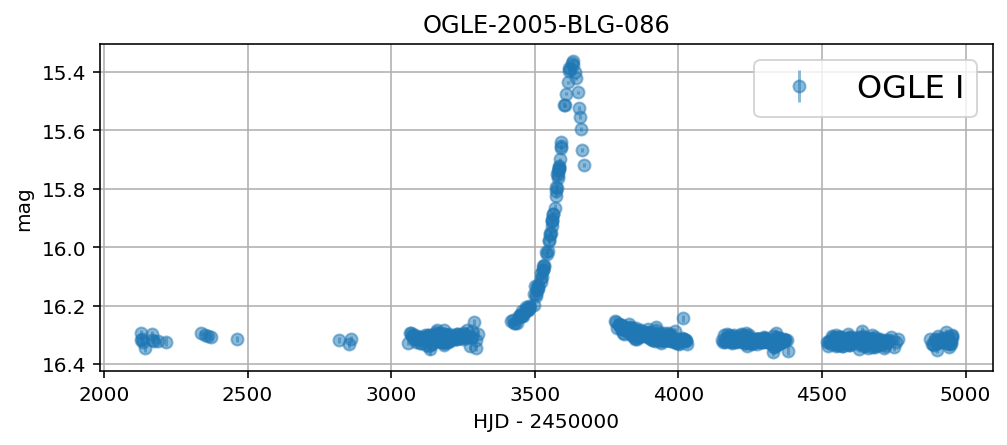

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm
import theano.tensor as T

import caustic as ca
import exoplanet as xo

import random

random.seed(42)

# Load event data
event_dir = "../../data/OB05086/"
event = ca.data.OGLEData(event_dir)

# Plot data
fig, ax = plt.subplots(figsize=(8, 3))
event.plot(ax);

## Fitting a PSPL model

First, let's optimize a simple PSPL model with white noise, and check the plot.

In [3]:
# Initialize a SingleLensModel object
model = ca.models.SingleLensModel(event)

with model:
    n_bands = len(event.light_curves)

    # Initialize linear parameters
    testval_ln_DeltaF = T.log(
        ca.utils.estimate_peak_flux(event) - ca.utils.estimate_baseline_flux(event)
    )  # helper functions
    ln_DeltaF = pm.Normal("ln_DeltaF", mu=4.0, sd=4, testval=testval_ln_DeltaF[0])
    DeltaF = T.exp(ln_DeltaF)

    ln_Fbase = pm.Normal(
        "ln_Fbase", mu=2, sd=4, testval=T.log(ca.utils.estimate_baseline_flux(event)[0])
    )
    Fbase = T.exp(ln_Fbase)

    # Initialize nonlinear parameters
    t0 = pm.Uniform(
        "t0", model.t_min, 2 * model.t_max, testval=ca.utils.estimate_t0(event)
    )
    ln_tE = pm.Normal("ln_tE", mu=3.0, sd=6, testval=2.0)

    tE = pm.Deterministic("tE", T.exp(ln_tE))

    u0 = pm.Exponential("u0", 0.5, testval=0.1)

    # Compute the source magnitude and blending fraction
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(
        event, DeltaF, Fbase, u0
    )
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)

    # Compute the trajectory of the les
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u = trajectory.compute_trajectory(model.t)

    # Compute the magnification
    mag = model.compute_magnification(u, u0)

    # Compute the mean model
    mean = DeltaF * mag + Fbase

    # We allow for rescaling of the error bars by a constant factor
    ln_c = pm.Exponential("ln_c", 0.5, testval=0.8 * T.ones(n_bands), shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (T.exp(ln_c) * model.sigF) ** 2

    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model.compute_log_likelihood(model.F - mean, var_F)
    pm.Potential("log_likelihood", ll)

In [4]:
with model:
    # Print initial logps
    print("Model test point:\n", model.check_test_point())

    # Run sampling
    trace = pm.sample(tune=500, draws=1000, cores=4, step=xo.get_dense_nuts_step())

Model test point:
 ln_DeltaF       -2.38
ln_Fbase        -2.63
t0_interval__   -1.86
ln_tE           -2.72
u0_log__        -3.05
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:49<00:00, 54.61draws/s] 
The number of effective samples is smaller than 25% for some parameters.


/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


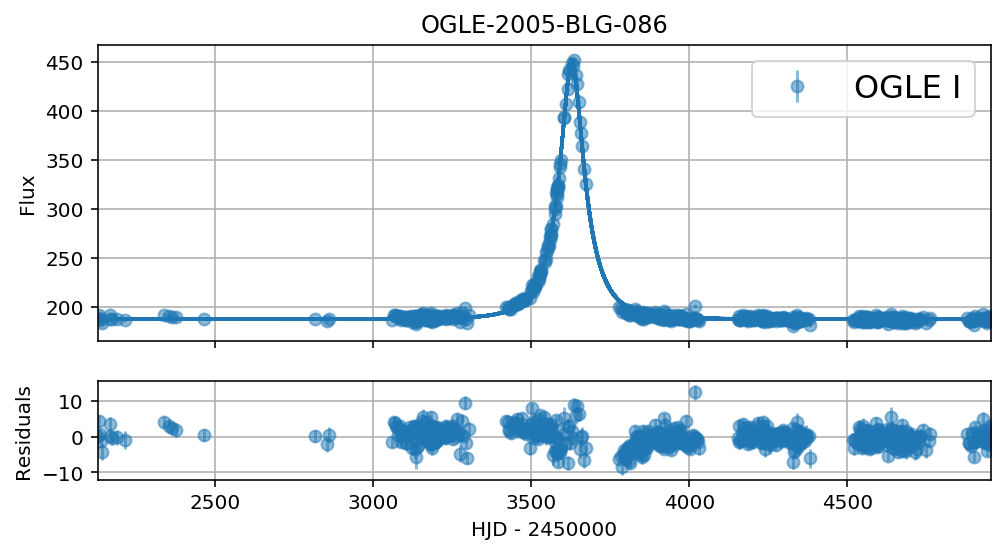

In [5]:
with model:
    # Create dense grid
    t_dense = np.tile(np.linspace(model.t_min, model.t_max, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE)
    u_dense = trajectory.compute_trajectory(t_dense_tensor)

    # Compute the magnification
    mag_dense = model.compute_magnification(u_dense, u0)

    # Compute the mean model
    mean_dense = T.exp(ln_DeltaF) * mag_dense + T.exp(ln_Fbase)

# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 4), sharex=True
)

samples = list(xo.get_samples_from_trace(trace, size=50))
with model:
    ca.plot_model_and_residuals(ax, event, trace, t_dense_tensor, mean_dense)

We can see from the model plot in data space and the residuals with respect to the median of the model light curves that there is some asymmetry in the light curve, a classic sign of the annual parallax effect. Let's use a model which includes parallax instead.

## Including parallax

Let's not fit a parallax model using the standard parametrization which adds two parameters $\pi_{E,E}$ and $\pi_{E,N}$ compared to the PSPL model. As we will see, the posterior is multi-modal and the results are sensitive
to the initializion of the sampler.

In [6]:
# Initialize a SingleLensModel object
model_parallax = ca.models.SingleLensModel(event)

with model_parallax:
    n_bands = len(event.light_curves)

    # Initialize linear parameters
    testval_ln_DeltaF = T.log(
        ca.utils.estimate_peak_flux(event) - ca.utils.estimate_baseline_flux(event)
    )  # helper functions
    ln_DeltaF = pm.Normal("ln_DeltaF", mu=4.0, sd=4, testval=testval_ln_DeltaF[0])
    DeltaF = T.exp(ln_DeltaF)

    ln_Fbase = pm.Normal(
        "ln_Fbase", mu=2, sd=4, testval=T.log(ca.utils.estimate_baseline_flux(event)[0])
    )
    Fbase = T.exp(ln_Fbase)

    # Initialize nonlinear parameters
    t0 = pm.Uniform(
        "t0", model.t_min, 2 * model.t_max, testval=ca.utils.estimate_t0(event)
    )
    ln_tE = pm.Normal("ln_tE", mu=3.0, sd=6, testval=2.0)
    tE = pm.Deterministic("tE", T.exp(ln_tE))

    # In the parallax model, u_0 can be negative
    u0 = pm.Normal("u0", mu=0.0, sd=3, testval=-0.41)

    # Initialize the two parallax parameters
    piEE = pm.Normal("piEE", mu=0.0, sigma=1.0, testval=0.1)
    piEN = pm.Normal("piEN", mu=0.0, sigma=1.0, testval=-0.3)

    # Deterministic transformations
    m_source, g = ca.compute_source_mag_and_blend_fraction(event, DeltaF, Fbase, u0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    pm.Deterministic("piE", T.sqrt(piEE ** 2 + piEN ** 2))

    # Compute the trajectory including parallax
    trajectory = ca.trajectory.Trajectory(event, t0, u0, tE, piEE, piEN)
    u = trajectory.compute_trajectory(model_parallax.t)

    # Compute the magnification
    mag = model_parallax.compute_magnification(u, u0)

    # Compute the mean model
    mean = DeltaF * mag + Fbase

    # We allow for rescaling of the error bars by a constant factor
    ln_c = pm.Exponential("ln_c", 0.5, testval=0.8 * T.ones(n_bands), shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (T.exp(ln_c) * model_parallax.sigF) ** 2

    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model_parallax.compute_log_likelihood(model_parallax.F - mean, var_F)
    pm.Potential("log_likelihood", ll)

    # We'll need this later
    pm.Deterministic("log_likelihood_", ll)

In [21]:
# Starting point in the parameter space
start = {"u0": 0.5, "piEE": 0.1, "piEN": 0.3}

with model_parallax:
    # Print initial logps
    print("Model check point:\n", model_parallax.check_test_point())

    # Run sampling
    trace_parallax = pm.sample(
        tune=500, draws=1000, start=start, cores=4, step=xo.get_dense_nuts_step()
    )

Model check point:
 ln_DeltaF       -2.38
ln_Fbase        -2.63
t0_interval__   -1.86
ln_tE           -2.72
u0              -2.03
piEE            -0.92
piEN            -0.96
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, piEN, piEE, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:39<00:00, 21.47draws/s]
The acceptance probability does not match the target. It is 0.9240392642821111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022908650728749, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9196448831575257, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9341519122404, but should be close to 0.8. Try to increase the number of tuning steps.


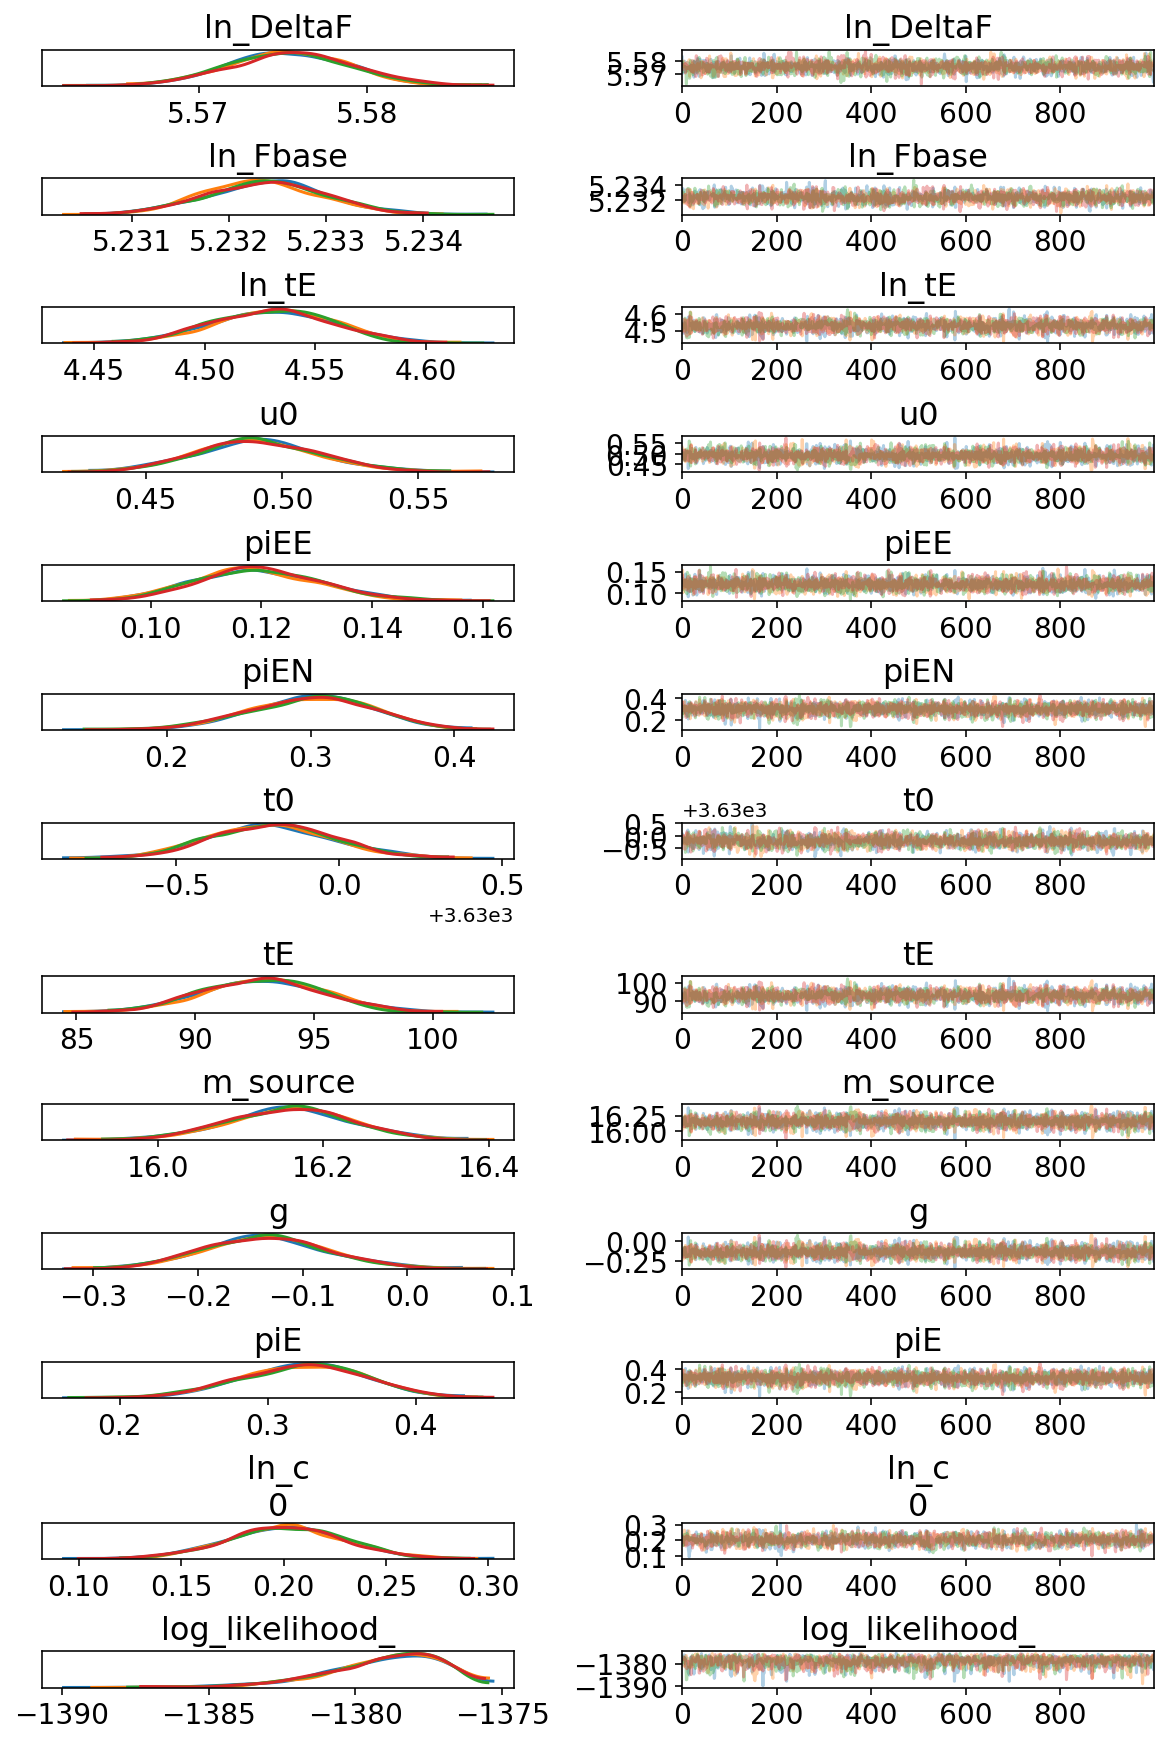

In [22]:
pm.traceplot(trace_parallax, figsize=(8, 12));

/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fb90/anaconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


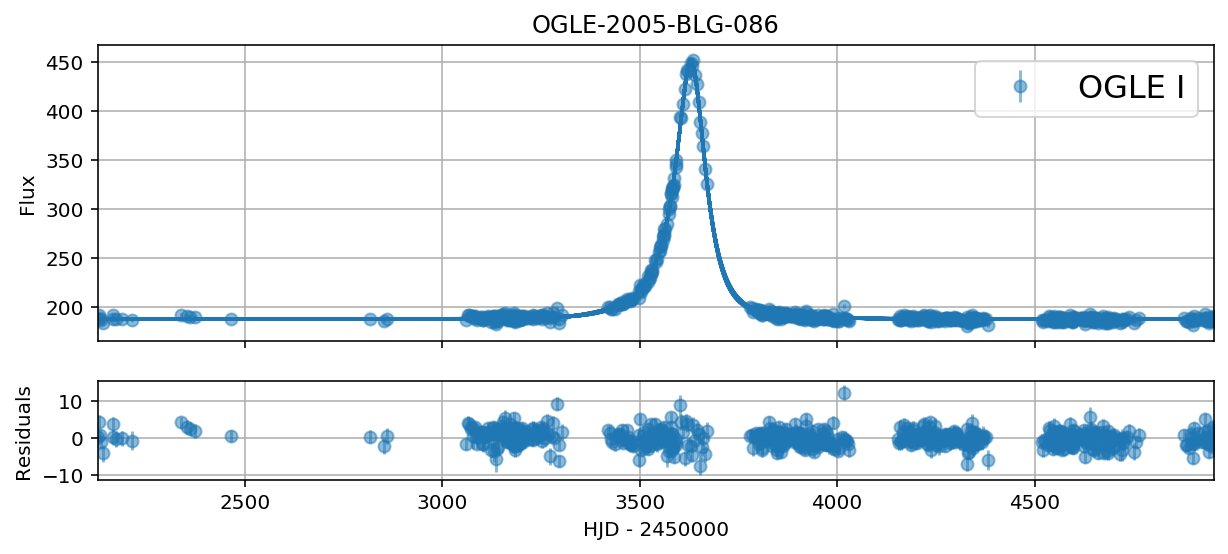

In [9]:
with model_parallax:
    # Create dense grid
    t_dense = np.tile(
        np.linspace(model_parallax.t_min, model_parallax.t_max, 1000), (n_bands, 1)
    )
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)

    # Compute the magnification
    mag_dense = model_parallax.compute_magnification(u_dense, u0)

    # Compute the mean model
    mean_dense = DeltaF * mag_dense + Fbase

# Plot model
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(10, 4), sharex=True
)

samples = xo.get_samples_from_trace(trace_parallax, size=50)
with model_parallax:
    ca.plot_model_and_residuals(ax, event, trace_parallax, t_dense_tensor, mean_dense)

### Finding the other modes
Unfortunately, even Hamiltonian Monte Carlo doesn't deal with multi-modal posteriors. 
Let's do the sampling again, but this time with a sligthly different initialization.

In [10]:
# Starting point in the parameter space
start2 = {"u0": -0.45, "piEE": 0.1, "piEN": -0.3}

with model_parallax:
    # Print initial logps
    print("Model check point:\n", model_parallax.check_test_point())

    # Run sampling
    trace_parallax2 = pm.sample(
        tune=500, draws=1000, start=start2, cores=4, step=xo.get_dense_nuts_step()
    )

Model check point:
 ln_DeltaF       -2.38
ln_Fbase        -2.63
t0_interval__   -1.86
ln_tE           -2.72
u0              -2.03
piEE            -0.92
piEN            -0.96
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, piEN, piEE, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:32<00:00, 22.05draws/s]
The acceptance probability does not match the target. It is 0.9098142202775326, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9444289855733965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9174185981384954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849233086162074, but should be close to 0.8. Try to increase the number of tuning steps.


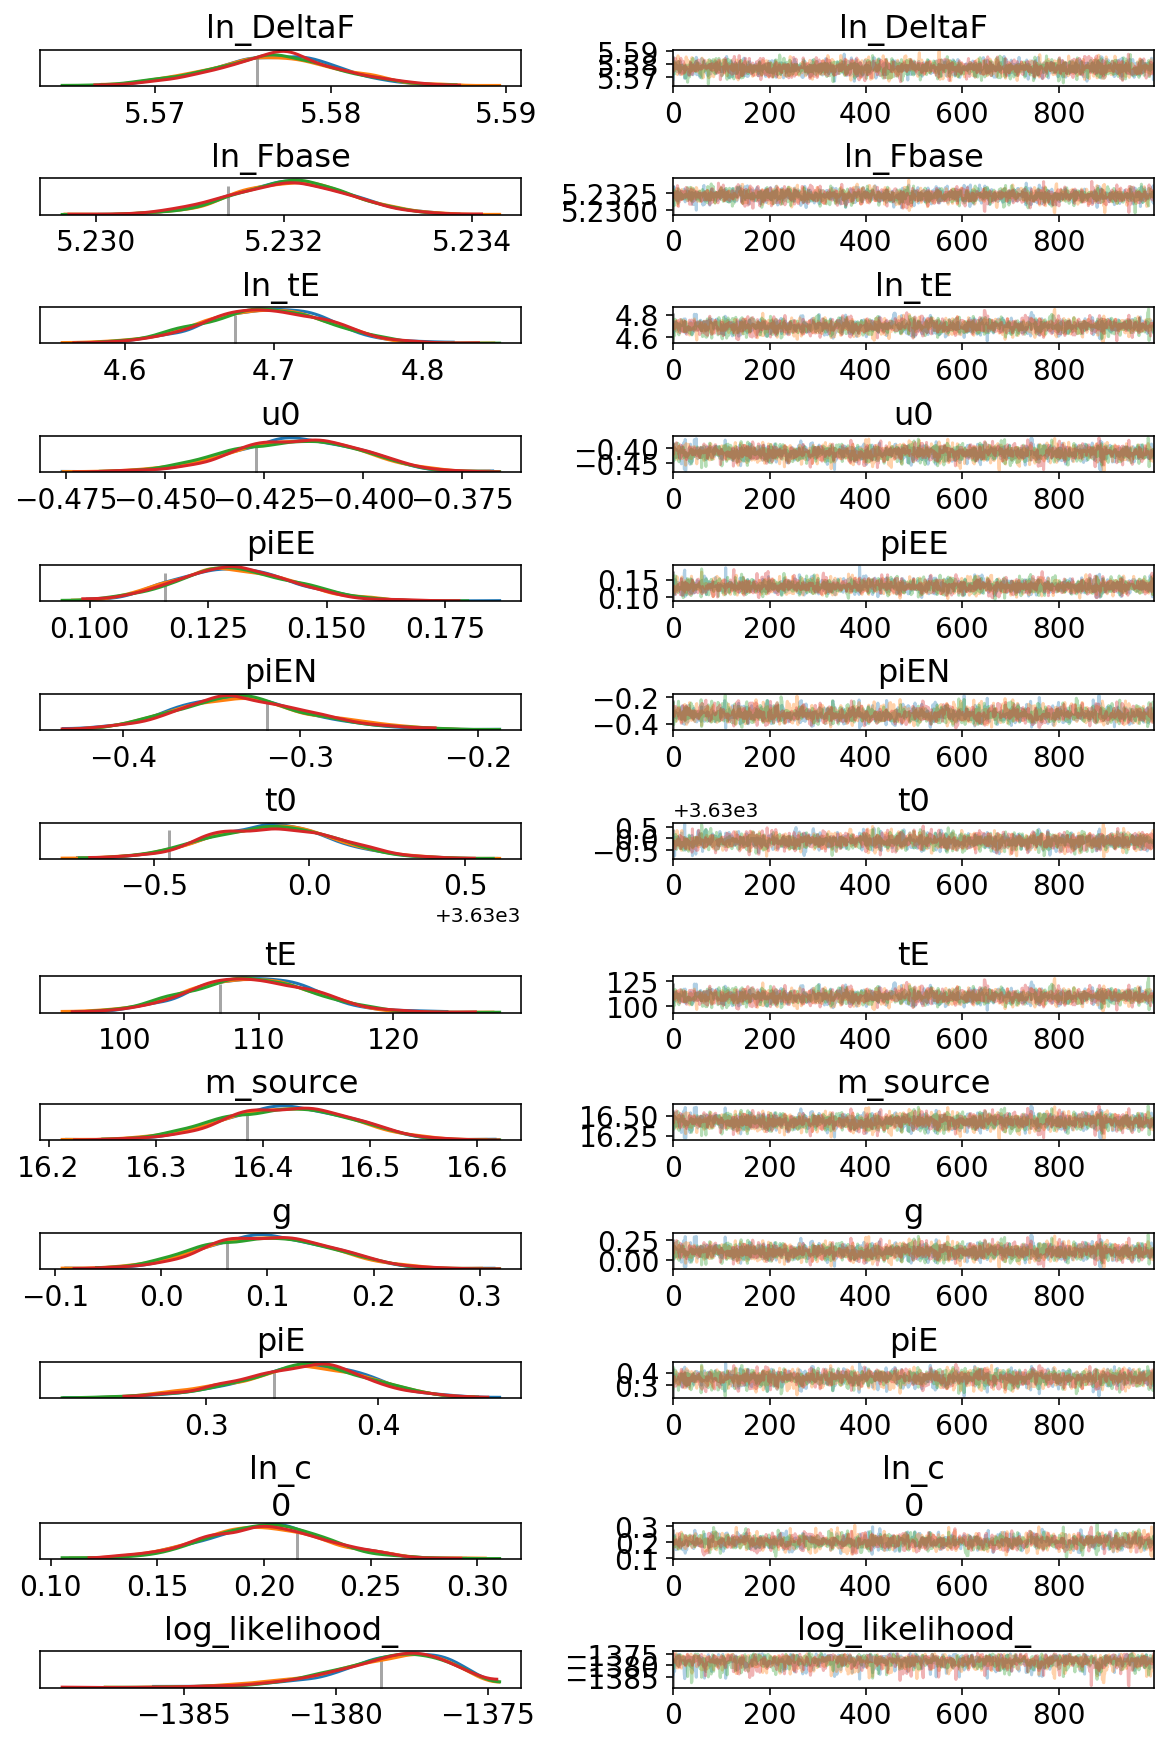

In [11]:
pm.traceplot(trace_parallax2, figsize=(8, 12));

In [12]:
# Starting point in the parameter space
start3 = {"u0": 0.1, "piEE": 0.05, "piEN": -0.4, "ln_tE": 5}

with model_parallax:
    # Print initial logps
    print("Model check point:\n", model_parallax.check_test_point())

    # Run sampling
    trace_parallax3 = pm.sample(
        tune=500, draws=1000, start=start3, cores=4, step=xo.get_dense_nuts_step()
    )

Model check point:
 ln_DeltaF       -2.38
ln_Fbase        -2.63
t0_interval__   -1.86
ln_tE           -2.72
u0              -2.03
piEE            -0.92
piEN            -0.96
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, piEN, piEE, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:39<00:00, 151.81draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8938921194084579, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8960612275058756, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9179226354767925, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is

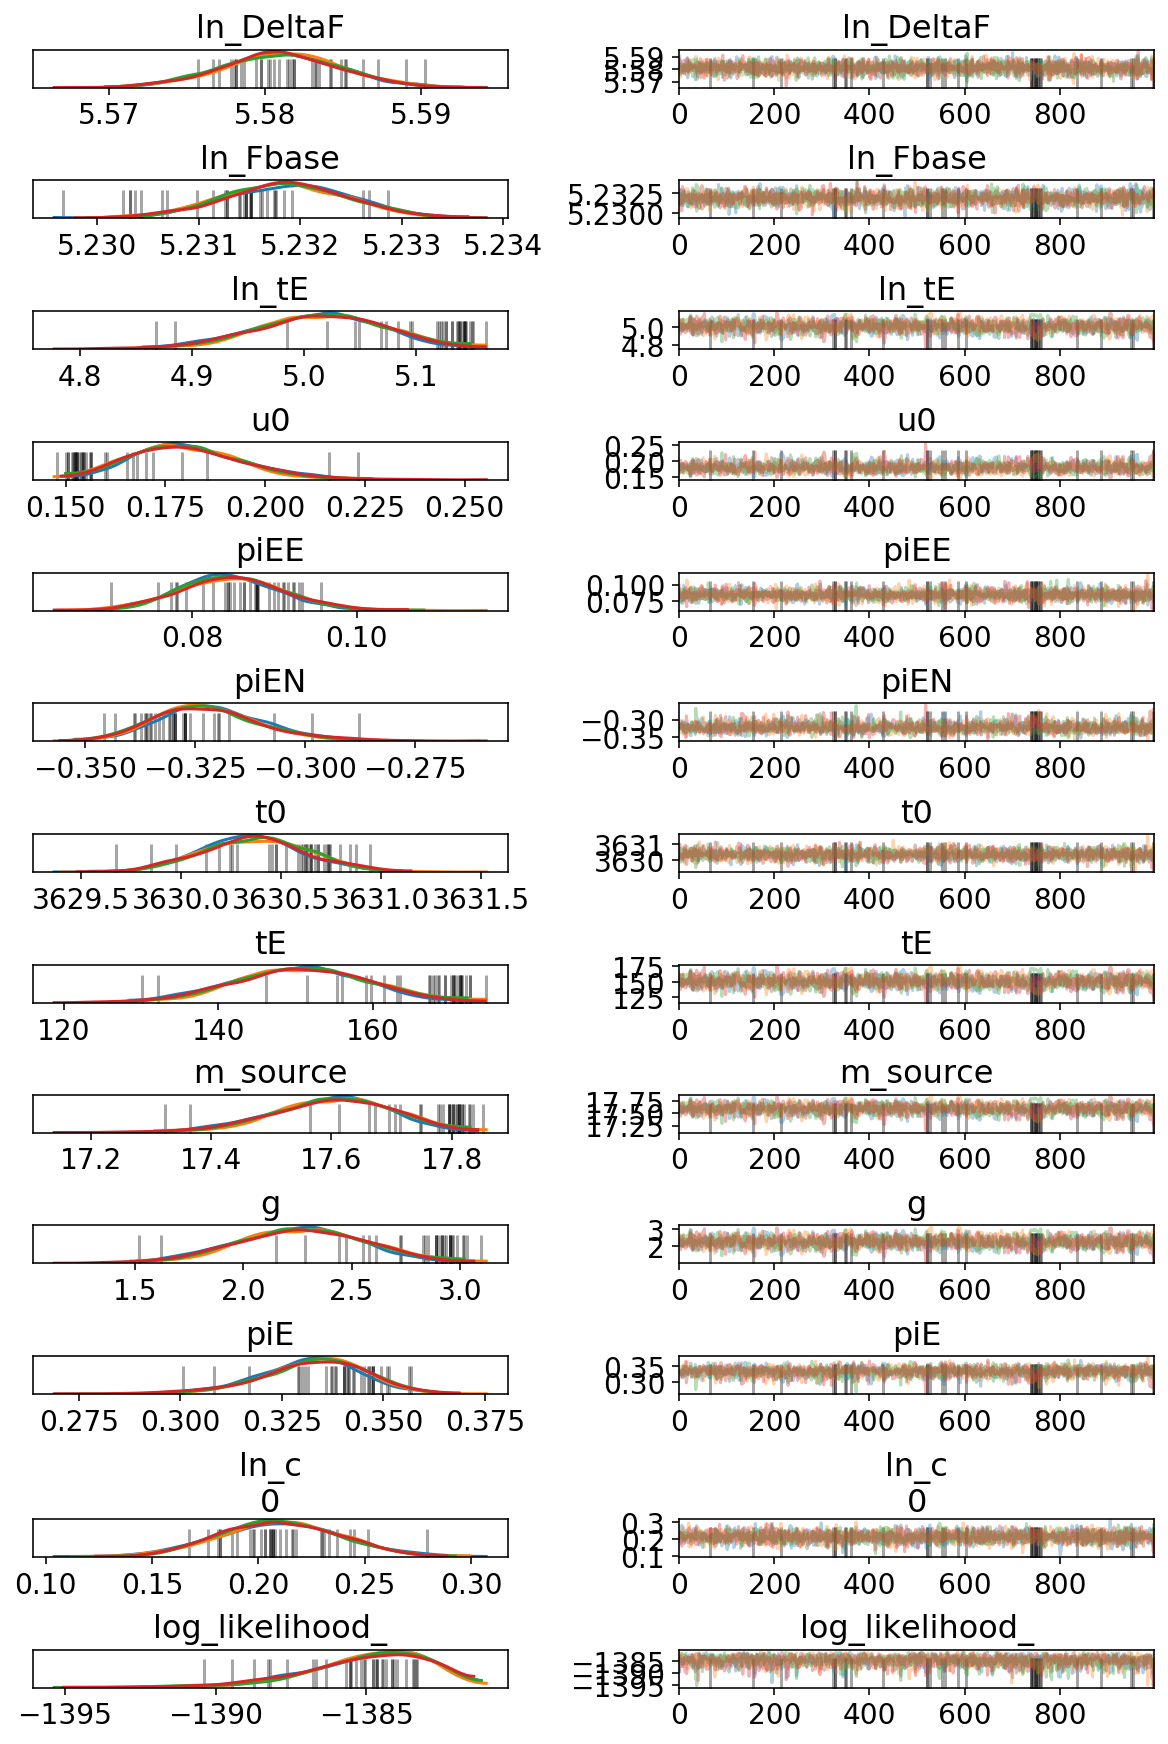

In [13]:
pm.traceplot(trace_parallax3, figsize=(8, 12));

And finally, the fourth mode

In [14]:
# Starting point in the parameter space
start4 = {"u0": -0.15, "piEE": 0.07, "piEN": 0.4, "ln_tE": 5.0}

with model_parallax:
    # Print initial logps
    print("Model check point:\n", model_parallax.check_test_point())

    # Run sampling
    trace_parallax4 = pm.sample(
        tune=500, draws=1000, start=start4, cores=4, step=xo.get_dense_nuts_step()
    )

Model check point:
 ln_DeltaF       -2.38
ln_Fbase        -2.63
t0_interval__   -1.86
ln_tE           -2.72
u0              -2.03
piEE            -0.92
piEN            -0.96
ln_c_log__      -1.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ln_c, piEN, piEE, u0, ln_tE, t0, ln_Fbase, ln_DeltaF]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:25<00:00, 234.00draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8798126067589848, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


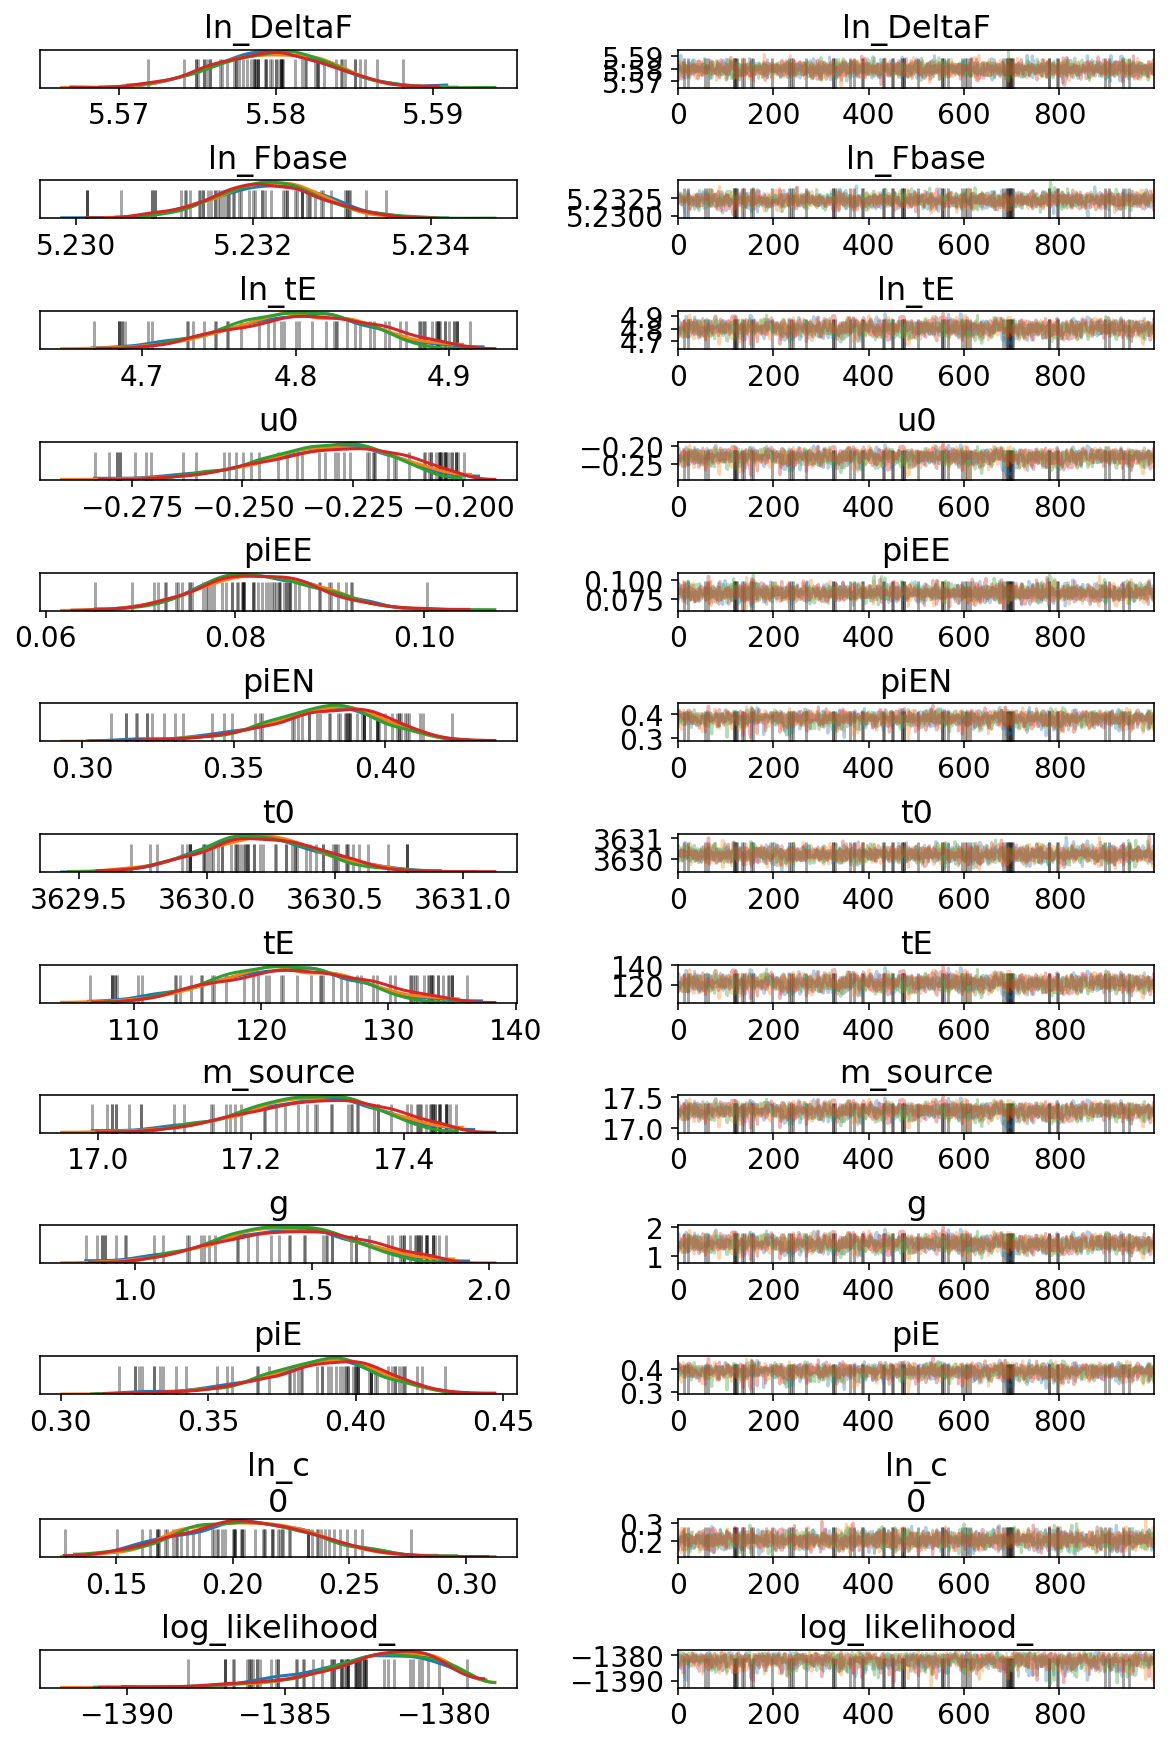

In [15]:
pm.traceplot(trace_parallax4, figsize=(8, 12));

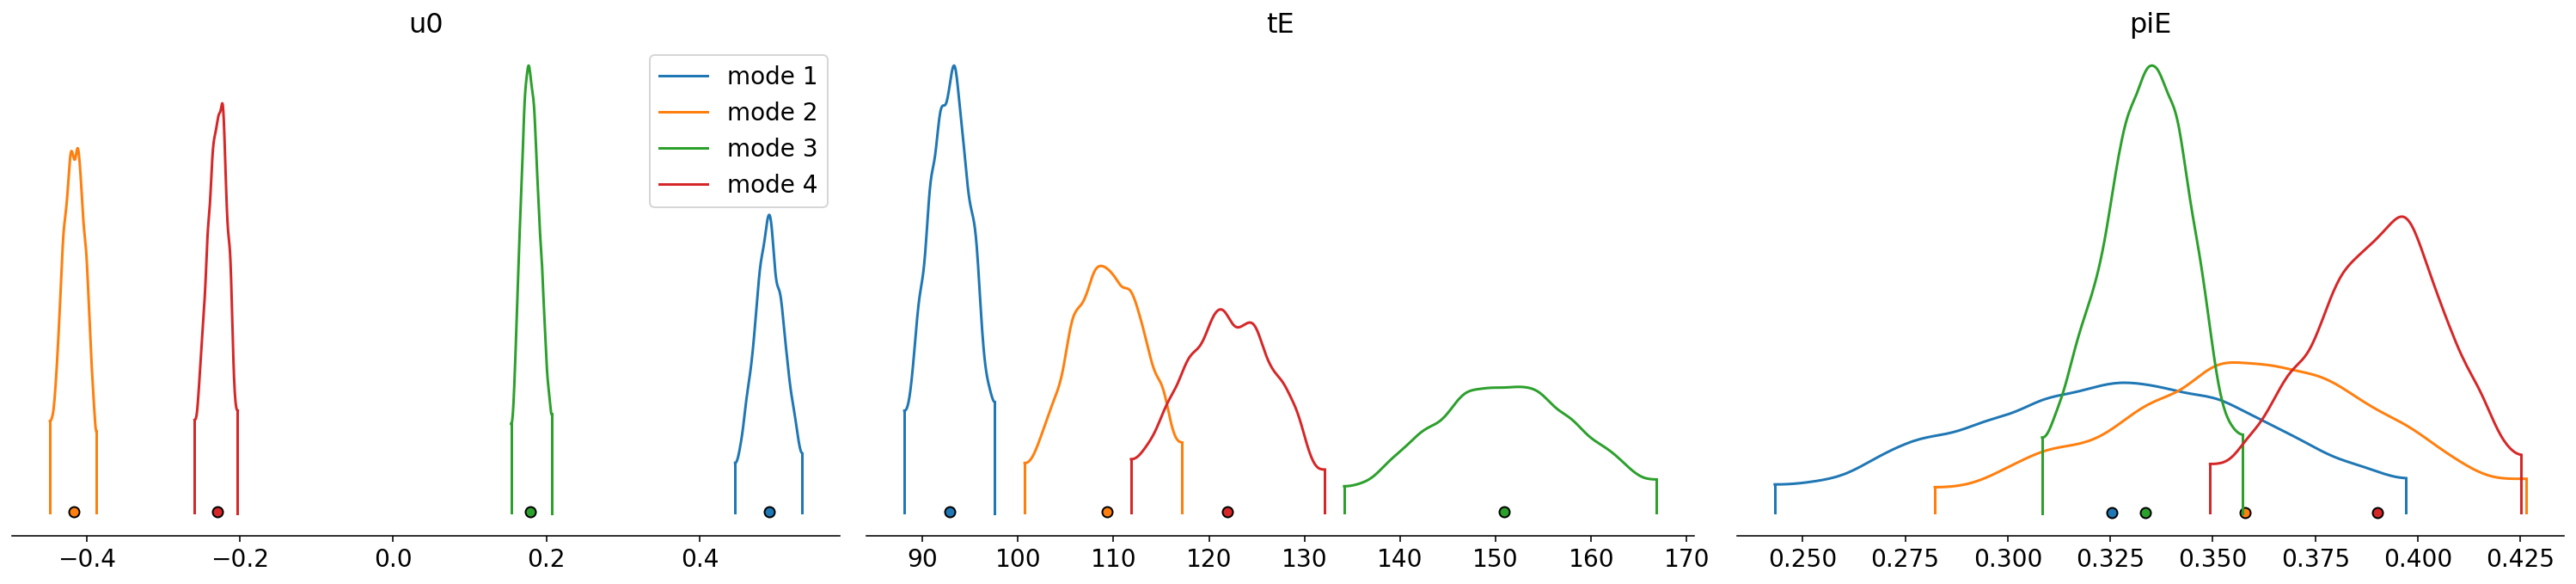

In [23]:
pm.plots.densityplot(
    [trace_parallax, trace_parallax2, trace_parallax3, trace_parallax4],
    var_names=["u0", "tE", "piE"],
    point_estimate="median",
    data_labels=["mode 1", "mode 2", "mode 3", "mode 4"],
);

There is clear multimodality in the posterior, especially in the $u_0$ parameter where there are 4 distinct modes. Let's plot the trajectories sampled from each of the modes.

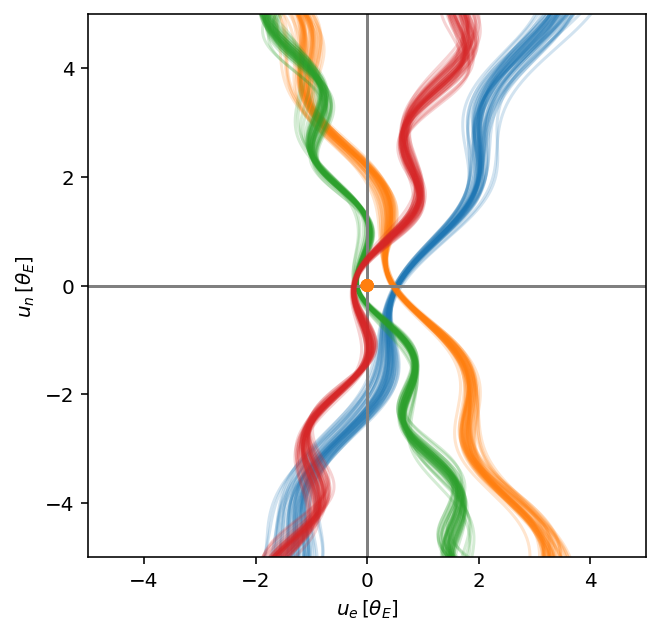

In [25]:
with model_parallax:
    # Create dense grid
    t_dense = np.tile(
        np.linspace(model_parallax.t_min, model_parallax.t_max, 1000), (n_bands, 1)
    )
    t_dense_tensor = T.as_tensor_variable(t_dense)

    # Evaluate trajectory components on dense grid
    u_n, u_e = trajectory.compute_trajectory(t_dense_tensor, return_components=True)

# Plot trajectories for all modes
fig, ax = plt.subplots(figsize=(5, 5))

samples1 = list(xo.get_samples_from_trace(trace_parallax, size=50))
samples2 = list(xo.get_samples_from_trace(trace_parallax2, size=50))
samples3 = list(xo.get_samples_from_trace(trace_parallax3, size=50))
samples4 = list(xo.get_samples_from_trace(trace_parallax4, size=50))

with model_parallax:
    ca.plot_trajectory_from_samples(ax, samples1, t_dense_tensor, u_n, u_e, color="C0")
    ca.plot_trajectory_from_samples(ax, samples2, t_dense_tensor, u_n, u_e, color="C1")
    ca.plot_trajectory_from_samples(ax, samples3, t_dense_tensor, u_n, u_e, color="C2")
    ca.plot_trajectory_from_samples(ax, samples4, t_dense_tensor, u_n, u_e, color="C3")

We can see that the cause of multi-modality is that that there are different plausible trajectories of the lens on the plane of the sky. In the case of a model without parallax, there is complete ambiguity for the path which the lens took because the light curve is only sensitive to the point of closest approach. Parallax breaks this ambiguity somewhat, but there is still no unique mode in the posterior.

## Comparing the different modes 

To compare the different modes we simply compare the values of the likelihood at each of the different modes. 
We'll compute the expected value of $-2\ln\mathcal{L}(\theta)|D)$ or the $\chi^2$. This is the first part of the
DIC information criterion used for model comparison:
$$\mathrm{DIC}=\bar D + p_D$$
where 
$$\bar D=\mathbb{E}_{p(\boldsymbol\theta|D)}[-2\ln\mathcal{L}(\theta|D)]$$

and $p_D$ is the effective number of parameters which we can neglect because we're comparing different modes
of the same model (as specified by the likelihood function and the priors) so the number of parameters
is constant.

In [18]:
def compute_expected_chisq(pm_model, trace):
    # Evaluate expectation value of log likelihood
    mean_deviance = np.sum(-2 * trace["log_likelihood_"]) / float(len(trace))

    return mean_deviance


chisq_1 = compute_expected_chisq(model_parallax, trace_parallax)
chisq_2 = compute_expected_chisq(model_parallax, trace_parallax2)
chisq_3 = compute_expected_chisq(model_parallax, trace_parallax3)
chisq_4 = compute_expected_chisq(model_parallax, trace_parallax4)

In [19]:
print(chisq_1)
print(chisq_2)
print(chisq_3)
print(chisq_4)

11029.256286383677
11026.665690685939
11079.734735654774
11057.151051966764


In [20]:
print("chisq_2", chisq_2)
print("chisq_1 - chisq_2", chisq_1 - chisq_2)
print("chisq_3 - chisq_2", chisq_3 - chisq_2)
print("chisq_4 - chisq_2", chisq_4 - chisq_2)

chisq_2 11026.665690685939
chisq_1 - chisq_2 2.590595697738536
chisq_3 - chisq_2 53.06904496883544
chisq_4 - chisq_2 30.4853612808256


Two of the modes (orange and blue in the plots) have comparable probability and the other two are negligible. 